In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import re
import h5py
import scipy.io as spio
import scipy as sp

import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool
import scipy.spatial.distance as dst
from scipy.stats import multivariate_normal
import scipy.optimize as op
import scipy as sp
sys.path.append('/home/yves/Documents/')
import twoptb as MP

kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

##  Helper Functions from Previous Stuff

In [2]:
def calc_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):
    
    """ Code essentially copied from implementation by Hooram Nam"""
    
    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)
    
    L1 = np.dot(np.ones(n_neurons*nT),np.exp(A))
    L2 =  ybar.dot(A)
    L3 =  xbar.T.dot(K_bigInv.dot(xbar))
    p = L1 - L2 + L3 
    return p

def calc_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):

    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    dL1 = np.dot(np.exp(A),C_big)
    dL2 = np.dot(ybar, C_big)
    dL3 = np.dot(xbar.T,  K_bigInv)

    dL = dL1 - dL2 + dL3

    return np.squeeze(dL)


def calc_post_hess(xbar, ybar, C_big, d, K_bigInv,t,n_neurons):
    
    nT = len(t)

    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    Aexpdiagonal = sp.sparse.spdiags(np.exp(A),0,n_neurons*nT,n_neurons*nT)
    temp = Aexpdiagonal.dot(C_big)

    ddL = np.dot(C_big.T, temp) +  K_bigInv
    return ddL

In [3]:
def CdtoVecCd(C, d):
    '''Given C,d returns vec(C,d).
    Parameters:
    ===========
      * C : numpy array of shape (xdim, ydim), loading matrix
      * d : numpy array of shape (ydim, 1), offset parameter
    Returns:
    ========
      * vecCd : numpy array of shape (xdim*ydim+ydim, 1), vectorized C,d
    '''
    ydim,xdim = np.shape(C)
    matCd = np.concatenate([C.T, np.asarray([d])]).T
    vecCd = np.reshape(matCd.T, xdim*ydim + ydim)
    return vecCd

def vecCdtoCd(vecCd, xdim, ydim):
    '''Given vecCd, xdim, ydim, returns C,d.
    Parameters:
    ===========
      * vecCd : numpy array of shape (xdim*ydim+ydim, 1), vectorized C,d
      * xdim : int, latent dimensionality
      * ydim : int, number of neurons
    
    Returns:
    ========
      * C : numpy array of shape (xdim, ydim), loading matrix
    '''
    matCd = np.reshape(vecCd, [xdim+1, ydim]).T
    C = matCd[:,:xdim]
    d = matCd[:,xdim]
    return C, d

In [4]:
def MStepObservationCost(vecCd, xdim, ydim, y, x_post_mean, postCov):
    '''
    Function written Macke, Buesing, Sahani 2015 for the PLDS model.
    The Observation parameter cost function is identical to the P-GPFA model.
    Translated to Python by Hooram Nam 2015
    '''
    T = nT
    xdim,ydim = nDims,n_neurons
    C,d = vecCdtoCd(vecCd, xdim ,ydim)

    CC = np.zeros([ydim,xdim**2])

    for yd in range(ydim):
        CC[yd,:] = np.reshape(np.outer(C[yd,:],C[yd,:]),xdim**2)

    f = 0
    df = np.zeros(np.shape(C))
    dfd = np.zeros(ydim)

    y = y
    m = x_post_mean
    vsm = np.reshape(postCov,[T,xdim**2])

    hh = (np.dot(C,m) + np.asarray([d]).T)
    rho = (np.dot(CC, vsm.T))
    yhat = np.exp(hh+rho/2)
    f = f + sum(sum(y*hh-yhat))

    return -f

In [5]:
def MStepObservationCost_grad(vecCd, xdim, ydim, y, x_post_mean,post_vsm):
    '''
    Function written Macke, Buesing, Sahani 2015 for the PLDS model.
    The Observation parameter cost function is identical to the P-GPFA model.
    Translated to Python by Hooram Nam 2015
    '''
    T = nT
    xdim,ydim = nDims,n_neurons
    C, d = vecCdtoCd(vecCd, xdim, ydim)

    CC = np.zeros([ydim,xdim**2])

    for yd in range(ydim):
        CC[yd,:] = np.reshape(np.outer(C[yd,:],C[yd,:]),xdim**2)

    dfC = np.zeros(np.shape(C_init))
    dfd = np.zeros(ydim)

    m = x_post_mean
    vsm = np.reshape(post_vsm,[T,xdim**2])

    hh = np.float64(np.dot(C,m) + np.asarray([d]).T)
    rho = np.float64(np.dot(CC, vsm.T))

    yhat = np.exp(hh+rho/2)

    vecC = np.reshape(C.T,xdim*ydim)

    T1 = np.reshape(np.dot(yhat,vsm).T, [xdim, xdim*ydim]).T
    T2 = (T1 * np.asarray([vecC]).T)
    T3 = np.reshape(T2.T,(xdim,xdim,ydim))
    TT = np.sum(T3,1)

    dfC = dfC + np.dot(y-yhat,m.T) - TT.T
    dfd = dfd + np.sum(y-yhat,1)
    
    vecdf = -CdtoVecCd(dfC,dfd)/1

    return vecdf


In [6]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [7]:
def calc_K(x,y=None,l=.5,add_offset=1e-3,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = (1-add_offset)*np.exp(-.5*distsSq/(l**2)) 
    
    cov += np.eye(len(x))*add_offset
    return cov

In [8]:
def make_Cbig(C,t):
    return np.kron(np.eye(len(t)),C)

In [9]:
def make_Kbig(params,t,nDims,epsNoise=1e-3):

    epsSignal = (1-epsNoise)
    nT = len(t)  #number of time points
    #nDims = params['C'].shape[1] #dimensionality of the latent space
    #nT is
    K_big = np.zeros([nT*nDims,nT*nDims])  
    R_big = np.zeros([nT*nDims,nT*nDims]) 

    for dim in range(nDims):

        for t1_idx,t1 in enumerate(t):

            for t2_idx,t2 in enumerate(t):

                K_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = epsSignal*np.exp((-0.5)*((t1-t2)**2/(params['l'][dim])**2))
                R_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = 1
    return K_big, R_big


#  Ok now lets generate Poisson Data

In [125]:
n_neurons = 55 #q
nDims = 6#
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
nT = len(t)

sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(nDims)]



C = np.random.normal(loc=0,scale=.5,size=(n_neurons,nDims))/2
d = np.random.randint(0,6,size=(n_neurons))/2



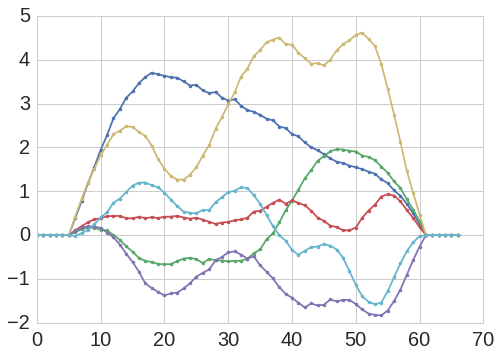

In [126]:
x = np.zeros([nDims,nT])

length_scales_GP = [10**(.3 if i== 0 else -i*.05) for i in range(nDims)]
params = {
          'l':length_scales_GP
         }
#params = [[4,1,2e0],
#          [1,2,1.5e-1],
#          [6,3,1e0]]

for i,l in enumerate(length_scales_GP):
    
    Ki = calc_K(x=t,y=t,l=l)
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[np.random.randint(1,7)-3]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(nT-35),np.cos(np.linspace(0,.5*np.pi,num=10)),np.zeros(5)])

for i in range(nDims):
    plt.plot(x[i],'.-')
    
#this is the observed data, which we pretend are the spike trains
rate_params = np.exp(C.dot(x) + d[:,None])
y = np.random.poisson(rate_params + np.abs(np.random.normal(loc=0,scale=1,size=rate_params.shape)))

In [127]:
true_params = {'C': C,
          'd': d,
          'l': length_scales_GP}

In [128]:
temp_vsmGP = np.zeros([nT,nT,nDims])
for kk in range(nDims):
    #This is the posterior covariance matrix across states, basically
    temp_vsmGP[:,:,kk] = PostCovGP[kk*nT:(kk+1)*nT, kk*nT:(kk+1)*nT]


ValueError: could not broadcast input array from shape (0,0) into shape (67,67)

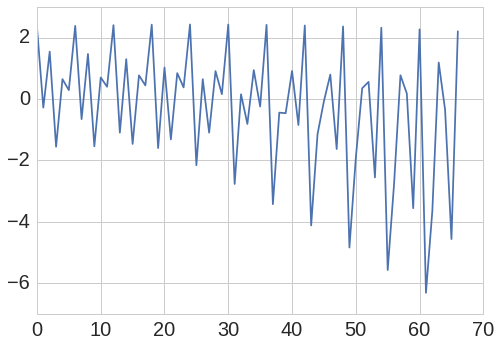

In [167]:
plt.plot(resLap.x.reshape(nDims,nT)[0])

In [166]:
resLap.x.reshape(nDims,nT).shape

(6, 67)

In [ ]:
temp_vsm.shape

In [129]:
a = PostCovGP[::nDims,0::nDims]

In [130]:
%%timeit

PostCovOther  = np.zeros(PostCovGP.shape)

for dim1 in range(nDims):
    for dim2 in range(nDims):
        PostCovOther[dim1*T:(dim1+1)*T,dim2*T:(dim2+1)*T] = PostCovGP[dim1::nDims,dim2::nDims]

ValueError: could not broadcast input array from shape (34,34) into shape (67,67)

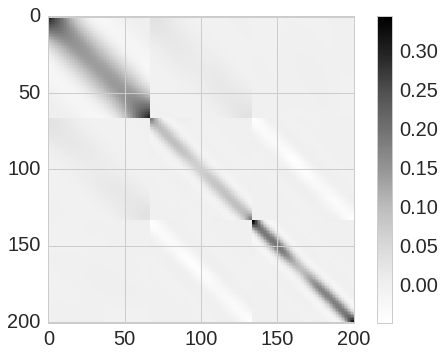

In [131]:
plt.imshow(PostCovOther,interpolation='None')
plt.colorbar()

In [132]:
st = time.time()
ybar = np.array([y.T.flatten()])

xSt = []
CdSt = []
Cst = []
dSt = []
#C_init = np.random.normal(size = C.shape)
#d_init = np.random.normal(size =d.shape)
#xInit = np.random.normal(size = x.shape)

nT = len(t)
nDims = true_params['C'].shape[1]


C_init = np.random.normal(size = (n_neurons,nDims))
d_init = np.random.normal(size =n_neurons)
xInit = np.random.normal(size = (nDims,nT))

nDims = C_init.shape[1]


covSt = []
xSt.append(xInit); Cst.append(C_init); dSt.append(d_init)
K_big,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)
C_big = make_Cbig(Cst[-1],t)
xbar = np.array([xSt[-1].T.flatten()]).T

maxEMiter = 200

for i in range(maxEMiter):
    print i,
    ########################################################################
    ##############               E-Step                     ################
    ########################################################################
    
    K_big,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)
    C_big = make_Cbig(Cst[-1],t)

    resLap = op.minimize(
        fun = calc_post_unNorm,
        x0 = xSt[-1],
        method='Newton-CG',
        args = (ybar, C_big, d, K_bigInv,t,n_neurons),
        jac = calc_post_grad,
        hess = calc_post_hess,
        options = {'disp': False,'maxiter': 10000,'xtol':1e-16
        })


    x_post_mean = resLap.x.reshape(nDims,nT,order='F')
    xSt.append(x_post_mean)
    xbar = np.array([xSt[-1].T.flatten()]).T


    hess = calc_post_hess(resLap.x,  ybar, C_big, d, K_bigInv,t,n_neurons)
    PostCovGP = np.linalg.inv(hess)
    #PostCovGP = PostCovGP

    PostCovOther  = np.zeros(PostCovGP.shape)

    for dim1 in range(nDims):
        for dim2 in range(nDims):
            PostCovOther[dim1*T:(dim1+1)*T,dim2*T:(dim2+1)*T] = PostCovGP[dim1::nDims,dim2::nDims]
    
    #PostCovGP = PostCovOther
    covSt.append(PostCovGP)
    

    temp_vsm = np.zeros([nT,nDims,nDims])
    for kk in range(nT):
        temp_vsm[kk][:,:] = PostCovGP[kk::nT,kk::nT]


    ########################################################################
    ##############               M-Step                     ################
    ########################################################################

    vecCd = CdtoVecCd(Cst[-1], dSt[-1])
    #xinit = np.random.normal(size=(xdim*ydim+ydim))#np.zeros(xdim*ydim+ydim)
    #xinit = vecCd + np.random.normal(size=(xdim*ydim+ydim))
    T = nT


    resCd = op.minimize(
                    fun = MStepObservationCost,
                    x0 = vecCd,
                    args = (nDims, n_neurons, y, xSt[-1], temp_vsm),
                    jac = MStepObservationCost_grad,
                    method = 'TNC',
                    options = {'disp': False, 'maxiter':4000,'ftol':1e-16,'gtol':1e-16,'xtol':1e-16}
                    )


    C_inf,D_inf = vecCdtoCd(resCd.x, nDims, n_neurons)
    Cst.append(C_inf); dSt.append(D_inf)
print time.time() - st

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 173.308238029


In [133]:
4579.9543252/60

76.33257208666667

# Plotting

In [134]:
U,D,V = sp.linalg.svd(Cst[-1])
xSVD = (np.dot(np.diag(D),V.T).dot(xSt[-1]))

In [135]:
U,D,V = sp.linalg.svd(C)
xSVD_true = (np.dot(np.diag(D),V.T).dot(x))

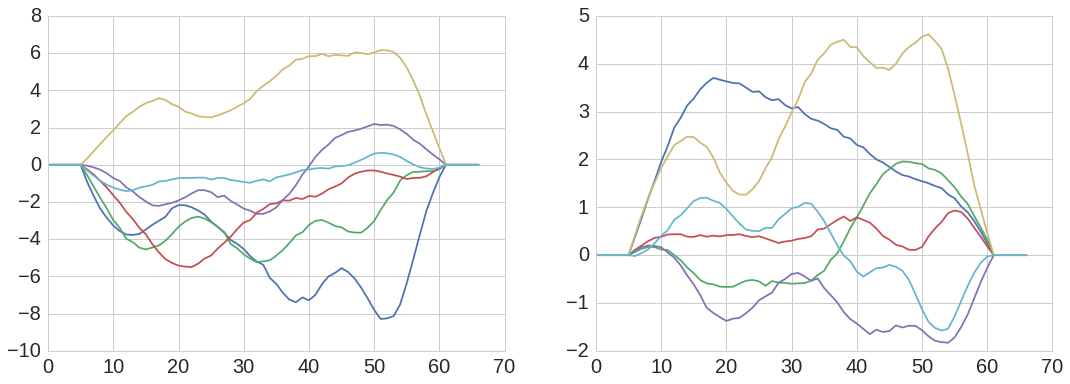

In [136]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
for i in xSVD_true:
    plt.plot(i)
    
plt.subplot(1,2,2)
for i in x:
    plt.plot(i)
    

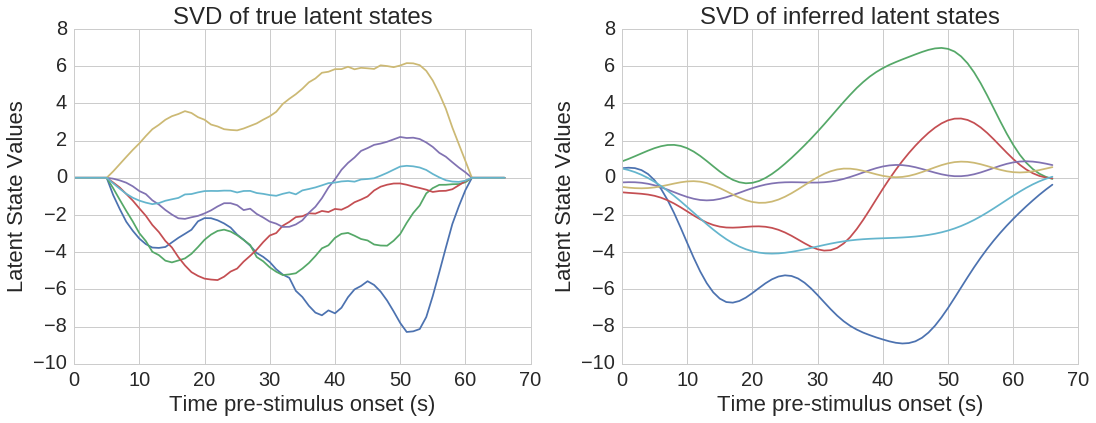

In [137]:
## Plot the SVD of the inferred and ground truth latent state trajectories
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title('SVD of true latent states')
for i in xSVD_true:
    plt.plot(i)
    plt.xlabel('Time pre-stimulus onset (s)')
    plt.ylabel('Latent State Values')
    
    
plt.subplot(1,2,2)
plt.title('SVD of inferred latent states')
for i in xSVD:
    plt.plot(i)
    plt.xlabel('Time pre-stimulus onset (s)')
    plt.ylabel('Latent State Values')

    

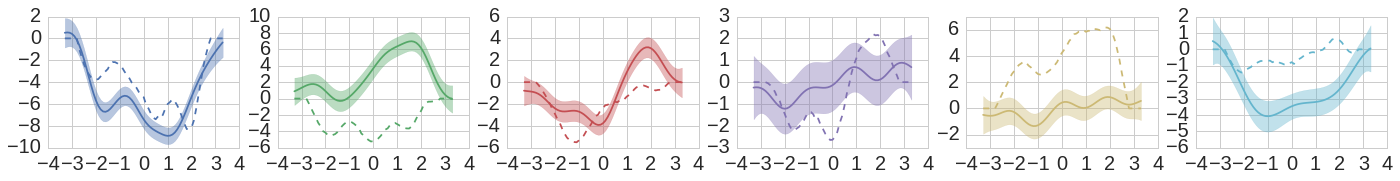

In [138]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)
SD2 = 3*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))

i = 0
for lapInf,gT in zip(xSVD,xSVD_true):
    plt.subplot(3,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    


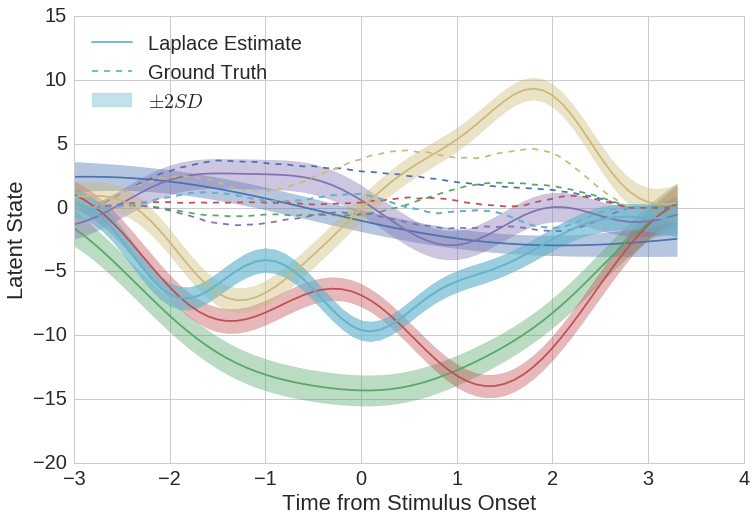

In [139]:
plt.figure(figsize=(12,8))
clrs = seaborn.color_palette('deep',n_colors=nDims+1,desat=1)#seaborn.color_palette('RdBu',n_colors=3)
SD2 = 3*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))
i = 0
for lapInf,gT in zip(xSt[-1],x):
    
    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

plt.ylabel('Latent State')
plt.xlabel('Time from Stimulus Onset')
plt.xlim(-3,)
plt.legend(loc='best')

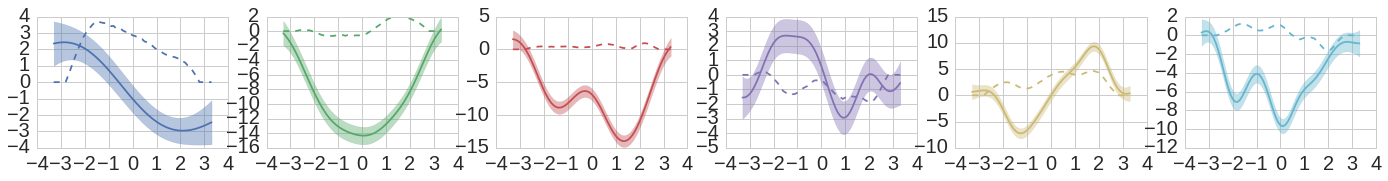

In [140]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(xSt[-1],x):
    plt.subplot(3,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    


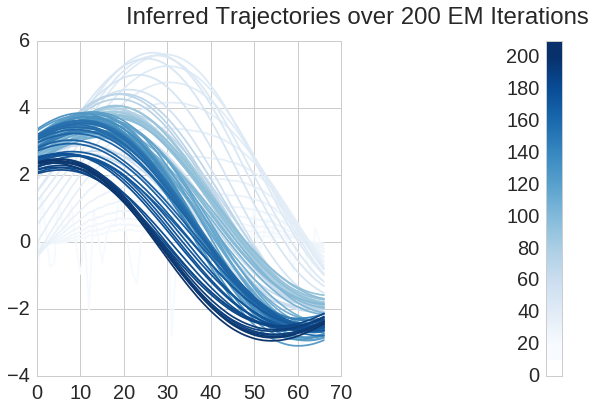

In [141]:
clrs = seaborn.color_palette('Blues',n_colors=int(2+len(xSt)/2),desat=.9)
plt.figure(figsize=(12,6))
plt.suptitle('Inferred Trajectories over %s EM Iterations \n' %maxEMiter)

plt.subplot(1,2,1)
for  i,xs in enumerate(xSt[0::2]):
    plt.plot(xs[0],color=clrs[i],alpha=1)
    
plt.subplot(1,2,2)
plt.imshow(np.flipud(np.array([range(10)]).T),aspect=2,cmap='Blues')
plt.xticks([])
plt.yticks(np.linspace(0,10,num=11),np.linspace(maxEMiter,0,num=11).astype('int'))
plt.grid()

## Plot Firing Rates

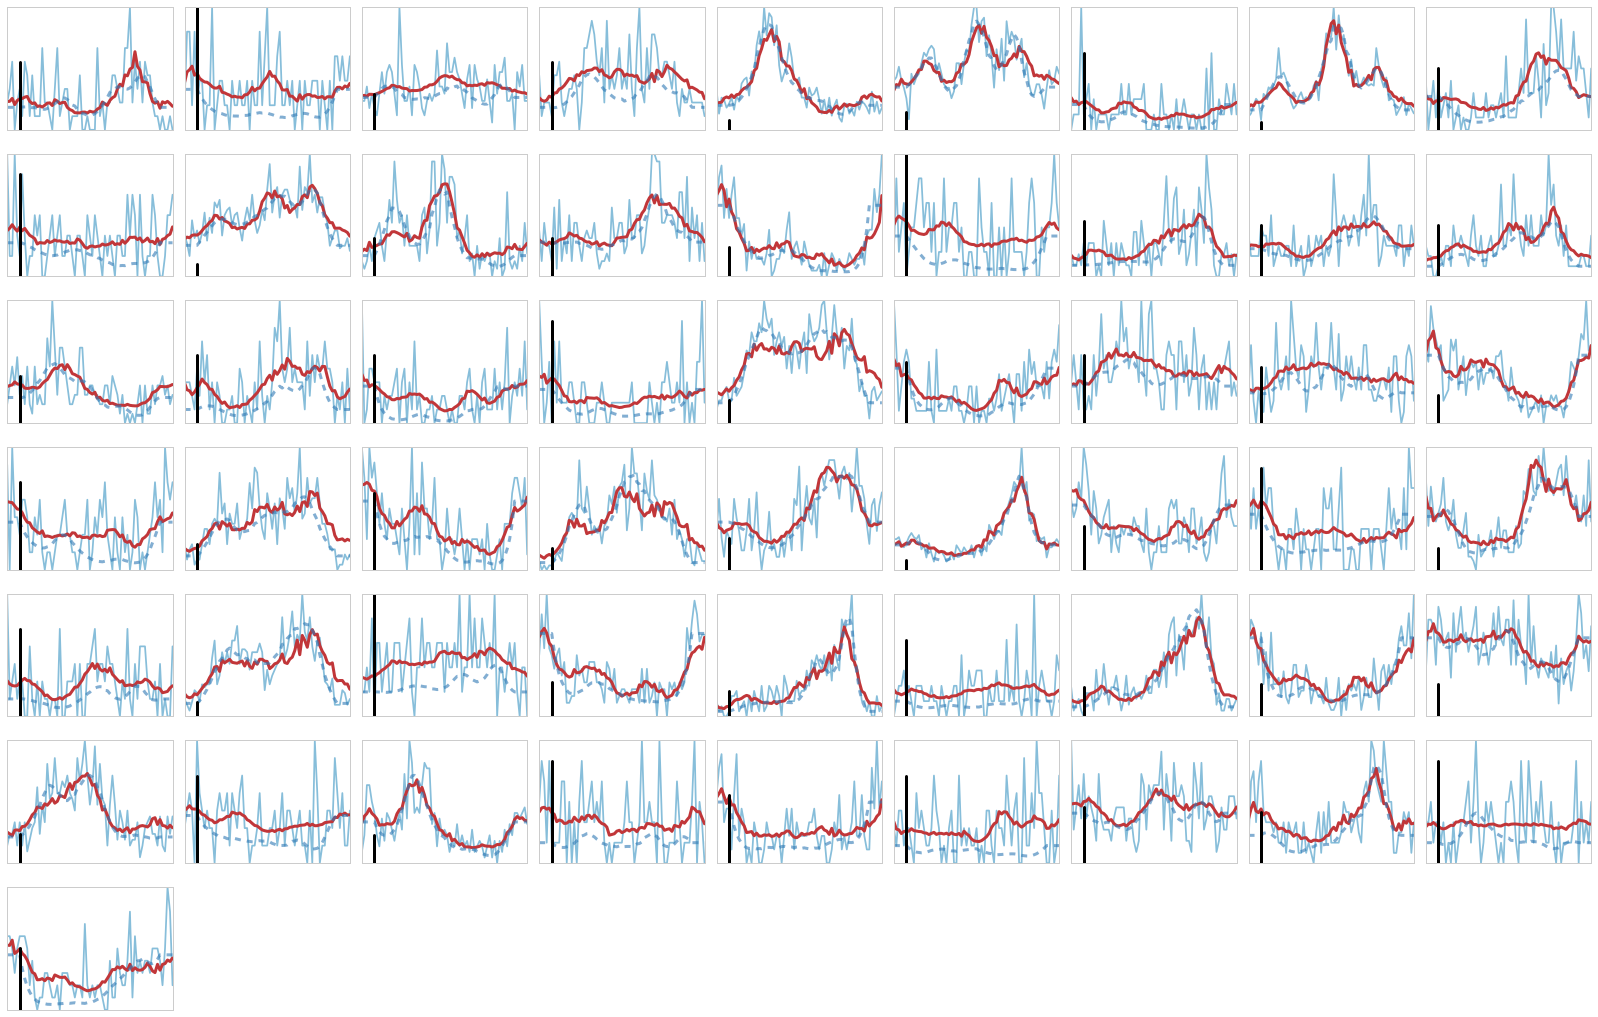

In [142]:
plt.figure(figsize=(22,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0

idx = 1
for real,sim in zip(np.exp(C.dot(x).T+d).T,
                    np.exp(Cst[idx].dot(xSt[idx]).T+dSt[idx]).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(sim,color=clrs[0],linewidth=3)
        plt.plot(real,'--',color=clrs[-1],linewidth=3,alpha=0.6)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        plt.plot([5,5],[0,5],linewidth=3,color='k')
        #plt.legend()
        
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


## Plot Some Real and Smoothing out spike Rates

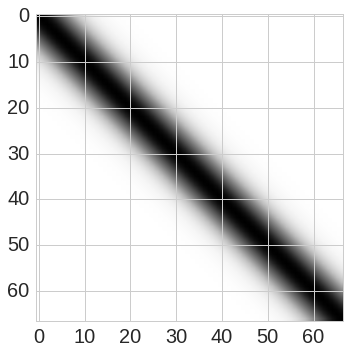

In [143]:
plt.imshow(Ki)

In [147]:
params['l'] = [params['l'][0]]*nDims

In [148]:
K2,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)

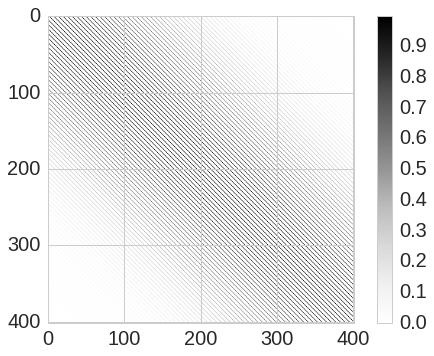

In [156]:
plt.imshow(K2)
plt.colorbar()

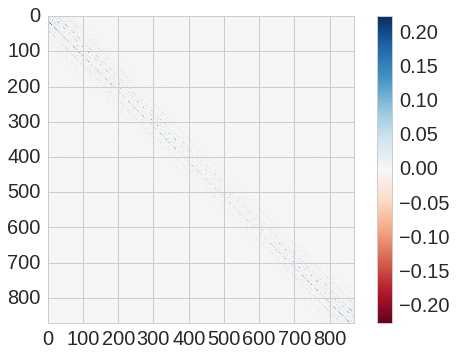

In [39]:
plt.imshow(PostCovGP,vmin=-np.max(PostCovGP),vmax=np.max(PostCovGP),interpolation='None',cmap='RdBu')
#plt.ylim(100,0)
#plt.xlim(0,100)
plt.colorbar()

In [157]:
plt.imshow(np.diff(np.kron(Ki,np.eye(nDims)),K2))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [153]:
Ki = calc_K(x=t,y=t,l=params['l'][0])


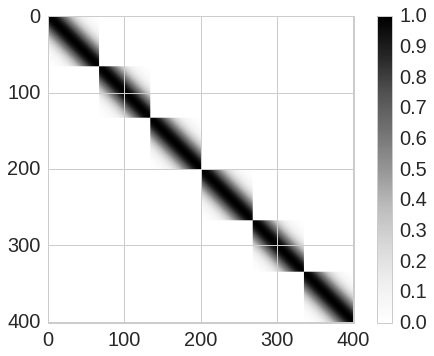

In [161]:
plt.imshow(np.kron(np.eye(nDims),Ki))
plt.colorbar()

In [50]:
newN = n.T.reshape(-1,67,order='F')
plt.figure(figsize=(32,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= 12,12

tt = 0
for real,sim in zip(rate_params,np.exp(C.dot(x_post_mean).T+d).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(real,color=clrs[0],linewidth=3,alpha=0.6)
        plt.plot(sim,color=clrs[-1],linewidth=3)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        #plt.legend()
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)


NameError: name 'n' is not defined

In [30]:
np.tile(np.asarray([np.arange(T)]),[T,1])+1

array([[ 1,  2,  3, ..., 65, 66, 67],
       [ 1,  2,  3, ..., 65, 66, 67],
       [ 1,  2,  3, ..., 65, 66, 67],
       ..., 
       [ 1,  2,  3, ..., 65, 66, 67],
       [ 1,  2,  3, ..., 65, 66, 67],
       [ 1,  2,  3, ..., 65, 66, 67]])

In [28]:
np.tile(np.asarray([np.arange(T)]).T,[1,T])+1

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  3,  3,  3],
       ..., 
       [65, 65, 65, ..., 65, 65, 65],
       [66, 66, 66, ..., 66, 66, 66],
       [67, 67, 67, ..., 67, 67, 67]])

#  Now Perform the Timescale_updates

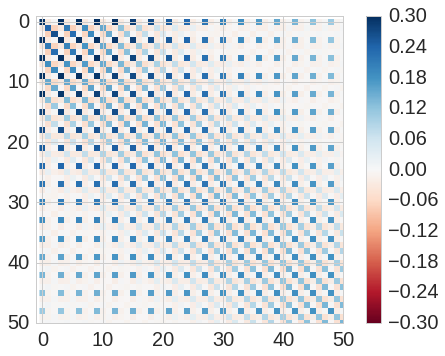

In [61]:
## In this matrix, along the diagonal have the autocorrelation
# Then along the 
plt.imshow(PostCovGP,cmap='RdBu',vmax=.3,vmin=-.3,interpolation='None')
plt.ylim(50,-1)
plt.xlim(-1,50)
plt.colorbar()

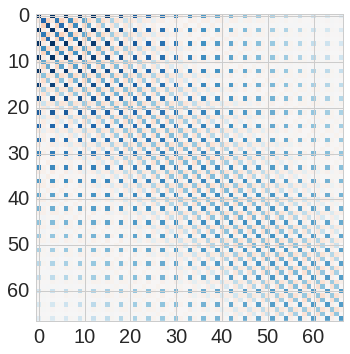

In [63]:
plt.imshow(PostCovGP[:nT,:nT],cmap='RdBu',vmax=.3,vmin=-.3,interpolation='None')


In [ ]:
temp_vsmGP = np.zeros([T,T,xdim])
for kk in range(xdim):
    #This is the posterior covariance matrix across states, basically
    temp_vsmGP[:,:,kk] = PostCovGP[kk*T:(kk+1)*T, kk*T:(kk+1)*T]
x_vsmGP.append(temp_vsmGP)

In [ ]:
# for tau

def makePrecomp(infRes):
    '''
    Function written by Byron & Yu 2009 for the GPFA model. 
    The timescale constant cost function is exactly the same as the P-GPFA case. 
    Translated to Python by Hooram Nam 2015
    '''
    xdim, T = np.shape(infRes['post_mean'][0])
    numTrials = len(infRes['post_mean'])

    Ttile1=np.tile(np.asarray([np.arange(T)]).T,[1,T])+1
    Ttile2=np.tile(np.asarray([np.arange(T)]),[T,1])+1
    Tdif = Ttile1-Ttile2
    difSq = Tdif*Tdif

    precomp = []
    PautoSum = []

    for xd in range(xdim):
        tempPautoSum = np.zeros([T,T])
        for tr in range(numTrials):
            tempPautoSum = tempPautoSum + infRes['post_vsmGP'][tr][:,:,xd] + np.outer(infRes['post_mean'][tr][xd,:],infRes['post_mean'][tr][xd,:])

        precomp.append({
            'T':T, 
            'Tdif':Tdif, 
            'difSq':difSq, 
            'numTrials':numTrials,
            'PautoSum':tempPautoSum})
    return precomp

def MStepGPtimescaleCost(p, precomp, epsNoise):
    '''
    Function written by Byron & Yu 2009 for the GPFA model. 
    The timescale constant cost function is exactly the same in the P-GPFA case. 
    Translated to Python by Hooram Nam 2015
    '''
    T = precomp['T']

    temp = (1-epsNoise)*np.exp(-np.exp(p)/2*precomp['difSq'])
    K = temp + epsNoise*np.eye(T)
    dKdgamma = -0.5*temp*precomp['difSq']
    
    dEdgamma = 0
    f = 0

    Thalf = int(np.ceil(T/2))
    Kinv = np.linalg.inv(K)
    sign, logdet = np.linalg.slogdet(K)
    logdet_K = sign*logdet

    KinvM = np.dot(Kinv[:Thalf,:],dKdgamma)
    KinvMKinv = np.dot(KinvM,Kinv)
    
    dg_KinvM = np.diag(KinvM)
    tr_KinvM = 2*sum(dg_KinvM) - T%2*dg_KinvM[-1]

    mkr = int(np.ceil(0.5*T**2))

    KinvVec = np.reshape(Kinv,T*T)
    PSallVec = np.reshape(precomp['PautoSum'],T*T)
    PS1vec = PSallVec[:mkr]
    PS2vec = PSallVec[mkr:]
    PS2vec = PS2vec[::-1]

    KinvMKinvVec = np.reshape(KinvMKinv, mkr)
    
    dEdgamma = -0.5*precomp['numTrials']*tr_KinvM + 0.5*np.dot(PS1vec,KinvMKinvVec)+ 0.5*np.dot(PS2vec,KinvMKinvVec)
    f = -0.5* precomp['numTrials']*logdet_K - 0.5*np.dot(PSallVec,KinvVec)

    return -f

def MStepGPtimescaleCost_grad(p, precomp, epsNoise):
    '''
    Function written by Byron, Yu in 2009 for the GPFA model. 
    The timescale constant cost function is exactly the same in the P-GPFA case. 
    Translated to Python by Hooram Nam 2015
    '''
    T = precomp['T']
    
    temp = (1-epsNoise)*np.exp(-np.exp(p)/2*precomp['difSq'])
    K = temp + epsNoise*np.eye(T)
    dKdgamma = -0.5*temp*precomp['difSq']
    
    dEdgamma = 0
    f = 0

    Thalf = int(np.ceil(T/2))
    Kinv = np.linalg.inv(K)
    sign, logdet = np.linalg.slogdet(K)
    logdet_K = sign*logdet

    KinvM = np.dot(Kinv[:Thalf,:],dKdgamma)
    KinvMKinv = np.dot(KinvM,Kinv)
    
    dg_KinvM = np.diag(KinvM)
    tr_KinvM = 2*sum(dg_KinvM) - T%2*dg_KinvM[-1]

    mkr = int(np.floor(0.5*T**2))

    KinvVec = np.reshape(Kinv,T*T)
    PSallVec = np.reshape(precomp['PautoSum'],T*T)
    PS1vec = PSallVec[:mkr]
    PS2vec = PSallVec[mkr:]
    PS2vec = PS2vec[::-1]

    KinvMKinvVec = np.reshape(KinvMKinv, mkr)
    
    dEdgamma = -0.5*precomp['numTrials']*tr_KinvM + 0.5*np.dot(PS1vec,KinvMKinvVec) + 0.5*np.dot(PS2vec,KinvMKinvVec)
    f = -0.5* precomp['numTrials']*logdet_K - 0.5*np.dot(PSallVec,KinvVec)

    return -dEdgamma*np.exp(p)

def learnGPparams(oldParams, infRes, experiment):
    xdim, T = np.shape(infRes['post_mean'][0])
    binSize = experiment.binSize
    oldTau = oldParams['tau']*1000/binSize
    
    precomp = makePrecomp(infRes)
    
    tempTau = np.zeros(xdim)

    pOptimizeDetails = [[]]*xdim
    for xd in range(xdim): 
        initp = np.log(1/oldTau[xd]**2)

        if False: # gradient check
            gradcheck = op.check_grad(MStepGPtimescaleCost,MStepGPtimescaleCost_grad,initp,precomp[0],0.001)
            print('tau learning grad check = ' + str(gradcheck))
            apprxGrad = op.approx_fprime(initp,MStepGPtimescaleCost,1e-8,precomp[xd],0.001)
            calcdGrad = MStepGPtimescaleCost_grad(initp,precomp[xd],0.001)
            plt.plot(apprxGrad,linewidth = 10, color = 'k', alpha = 0.4)
            plt.plot(calcdGrad,linewidth = 2, color = 'k', alpha = 0.4)
            plt.legend(['approximated','calculated'])
            plt.title('Approx. vs. calculated Grad of Tau learning cost')
            plt.tight_layout()
            plt.show()
            pdb.set_trace()

        res = op.minimize(
            fun = MStepGPtimescaleCost,
            x0 = initp,
            args = (precomp[xd], 0.001),
            jac = MStepGPtimescaleCost_grad,
            options = {'disp': False,'gtol':1e-8})
        pOptimizeDetails[xd] = res
        tempTau[xd] = (1/np.exp(res.x))**(0.5)

    newTau = tempTau*binSize/1000
    return newTau, pOptimizeDetails

def updateParams(oldParams, infRes, experiment, CdOptimMethod='BFGS', CdMaxIter=None, tauMaxIter=None, verbose=False):
    if verbose: print('Learning C,d...')
    newC, newd, obsOptimDetails = learnLTparams(
        oldParams = oldParams, 
        infRes = infRes, 
        experiment = experiment, 
        CdOptimMethod = CdOptimMethod, 
        CdMaxIter = CdMaxIter,
        verbose = verbose)    
    
    if verbose: print('Learning GP timescale constants')
    newTau, dynOptimDetails = learnGPparams(oldParams, infRes, experiment)
    newParams = {'C':newC, 'd':newd, 'tau':newTau}
    optimDetails = {'Cd':obsOptimDetails,'tau':dynOptimDetails}
    return newParams, optimDetails


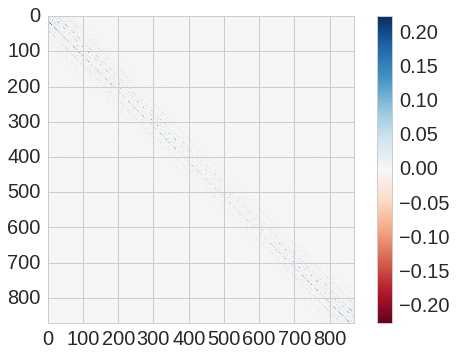

In [39]:
plt.imshow(PostCovGP,vmin=-np.max(PostCovGP),vmax=np.max(PostCovGP),interpolation='None',cmap='RdBu')
#plt.ylim(100,0)
#plt.xlim(0,100)
plt.colorbar()